# Loss

In [11]:
# !tail /workspace/zhouy/megatron-gw/1.2b.log
!cat /workspace/zhouy/megatron-gw/logs/rn+ss+sm.log | grep loss: > loss.log
!cat /workspace/zhouy/megatron-gw/logs/rn+ss+sm.log | grep 'validation loss' > validation_loss.log
!cat /workspace/zhouy/megatron-gw/logs/rn+ss+sm.log | grep match > match.log
# !cat /workspace/zhouy/megatron-gw/1.2b_softmask_verify/1.2b_soft_verify.log | grep loss: > loss.log
# !cat /workspace/zhouy/megatron-gw/1.2b_softmask_verify/1.2b_soft_verify.log | grep 'validation loss' > validation_loss.log
# !cat /workspace/zhouy/megatron-gw/1.2b_softmask_verify/1.2b_soft_verify.log | grep match > match.log

In [12]:
!which python
!pwd
!ls

/opt/conda/bin/python
/workspace/zhouy/megatron-gw/notebook
loss.log  match.log  validation_loss.log  visualize.ipynb


In [13]:
from tqdm import tqdm
import numpy as np

srcFile = open('match.log', 'r+')
lines = srcFile.readlines()
matches = []
for line in tqdm(lines):
    d1, d2 = eval(line.split('|')[0].split('match long value: ')[-1]), eval(line.split('|')[1].split('match short value:')[-1])
    matches.append([d1, d2])
matches = np.asarray(matches)
srcFile.close()

srcFile = open('validation_loss.log', 'r+')
lines = srcFile.readlines()
loss_valid = []
for line in tqdm(lines):
    d = eval(line.split('|')[1].split('lm loss value:')[-1])
    loss_valid.append(d)
srcFile.close()

srcFile = open('loss.log', 'r+')
lines = srcFile.readlines()
loss = []
for line in tqdm(lines):
    d = eval(line.split('|')[5].split(':')[1])
    loss.append(d)
srcFile.close()


100%|██████████| 455/455 [00:00<00:00, 98922.26it/s]


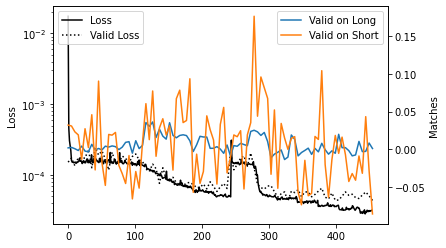

In [14]:
import matplotlib.pyplot as plt
plt.semilogy(loss, 'k-', label='Loss')
plt.plot(np.linspace(0, stop=len(loss), num=len(loss_valid)), loss_valid, 'k:', label='Valid Loss')
plt.legend(loc='upper left')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.linspace(0, stop=len(loss), num=len(matches)), matches[:,0], label='Valid on Long')
plt.plot(np.linspace(0, stop=len(loss), num=len(matches)), matches[:,1], label='Valid on Short')
plt.ylabel('Matches')
plt.legend()
plt.show()


# Match

In [15]:
!ls -lht /workspace/zhouy/megatron-gw/valid/rn+ss+sm_50000

total 128M
-rw-r--r-- 1 root root 192 Dec 28 16:33 match-0-96.npy
-rw-r--r-- 1 root root 736 Dec 28 16:33 param-0-96.npy
-rw-r--r-- 1 root root 32M Dec 28 16:33 data-0-96.npy
-rw-r--r-- 1 root root 192 Dec 28 16:33 match-0-64.npy
-rw-r--r-- 1 root root 736 Dec 28 16:33 param-0-64.npy
-rw-r--r-- 1 root root 32M Dec 28 16:33 data-0-64.npy
-rw-r--r-- 1 root root 192 Dec 28 16:33 match-0-32.npy
-rw-r--r-- 1 root root 736 Dec 28 16:33 param-0-32.npy
-rw-r--r-- 1 root root 32M Dec 28 16:33 data-0-32.npy
-rw-r--r-- 1 root root 192 Dec 28 16:33 match-0-0.npy
-rw-r--r-- 1 root root 736 Dec 28 16:33 param-0-0.npy
-rw-r--r-- 1 root root 32M Dec 28 16:33 data-0-0.npy


In [2]:
import numpy as np
valid = '0'
# iteration = '100'
# iteration = '150'
test = '32'
# data = np.load(f'/workspace/zhouy/megatron-gw/realtest/iteration_200{iteration}.npy')
# data = np.load(f'/workspace/zhouy/megatron-gw/realtest/iteration_2000_pretrain_345m_nomask.npy')
# data = np.load(f'/workspace/zhouy/megatron-gw/realtest/iteration_200500_pretrain_1.2b_softmask_0.17.npy')
# data = np.load(f'/workspace/zhouy/megatron-gw/realtest/iteration_1000_pretrain_345m_softmask_0.17.npy')
# data = np.load('/workspace/zhouy/megatron-gw/realtest/iteration_22500_pretrain_345m_softmask.npy')
data = np.load(f'/workspace/zhouy/megatron-gw/valid/rn+ss+sm_50000/data-0-{test}.npy')
denoised = data[:4]
noisy = data[4:8]
clean = data[8:12]
mask = data[12:]
denoised.shape

(4, 127, 2048)

In [3]:
import sys
sys.path.append('..')
sys.path.append('../GWToolkit')
# from gwtoolkit.redis import DatasetTorchRealEvent
from megatron.data.redis_dataset import DatasetTorchRealEvent, RedisDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

num_length = 2048
overlap = 0.5
mid_index = int(num_length*overlap)
rebuild_forer = lambda tokened_data: np.concatenate([d[:mid_index] for d in tokened_data[:-1]] + [tokened_data[-1]])
rebuild_backer = lambda tokened_data: np.concatenate([tokened_data[0]] + [d[mid_index:] for d in tokened_data[1:]])

def calc_matches(d1, d2):
    fft1 = np.fft.fft(d1)
    fft2 = np.fft.fft(d2)
    norm1 = np.mean(np.abs(fft1)**2)
    norm2 = np.mean(np.abs(fft2)**2)
    inner = np.mean(fft1.conj()*fft2).real
    return inner / np.sqrt(norm1 * norm2)

def metric(model_output, target_signal, mask, rebuild_on_forer=True):
    assert model_output.shape == target_signal.shape == mask.shape == (127, 2048)
    # (127, 2048) => (131072,)
    model_output = rebuild_forer(model_output) if rebuild_on_forer else rebuild_backer(model_output)
    target_signal = rebuild_forer(target_signal) if rebuild_on_forer else rebuild_backer(target_signal)
    mask = rebuild_forer(mask) if rebuild_on_forer else rebuild_backer(mask)
    # (131072,) => (2,)
    return (calc_matches(target_signal, model_output),
            calc_matches(mask * target_signal, mask * model_output))
            

In [3]:
# valid_dataset = RedisDataset('valid', 'nouse', port=5153)

match long: 0.4208539104895172, match short: 0.3111369592942313
match long: 0.4208539104895172, match short: 0.3111369592942313
match long: 0.4208539104895172, match short: 0.3111369592942313
match long: 0.4208539104895172, match short: 0.3111369592942313


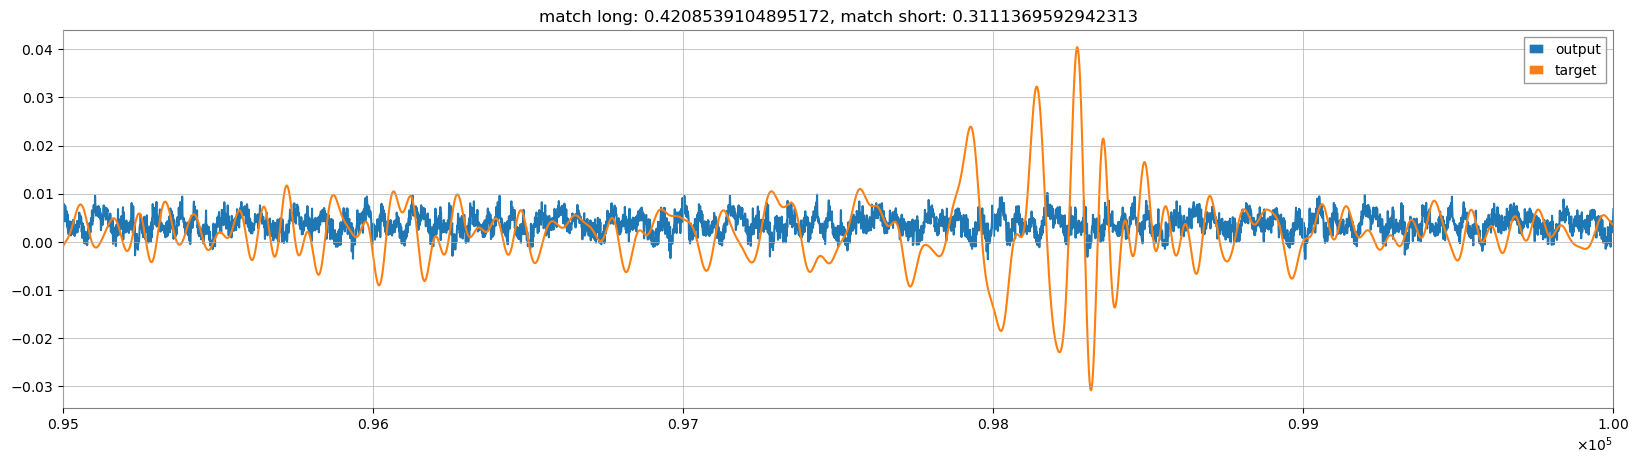

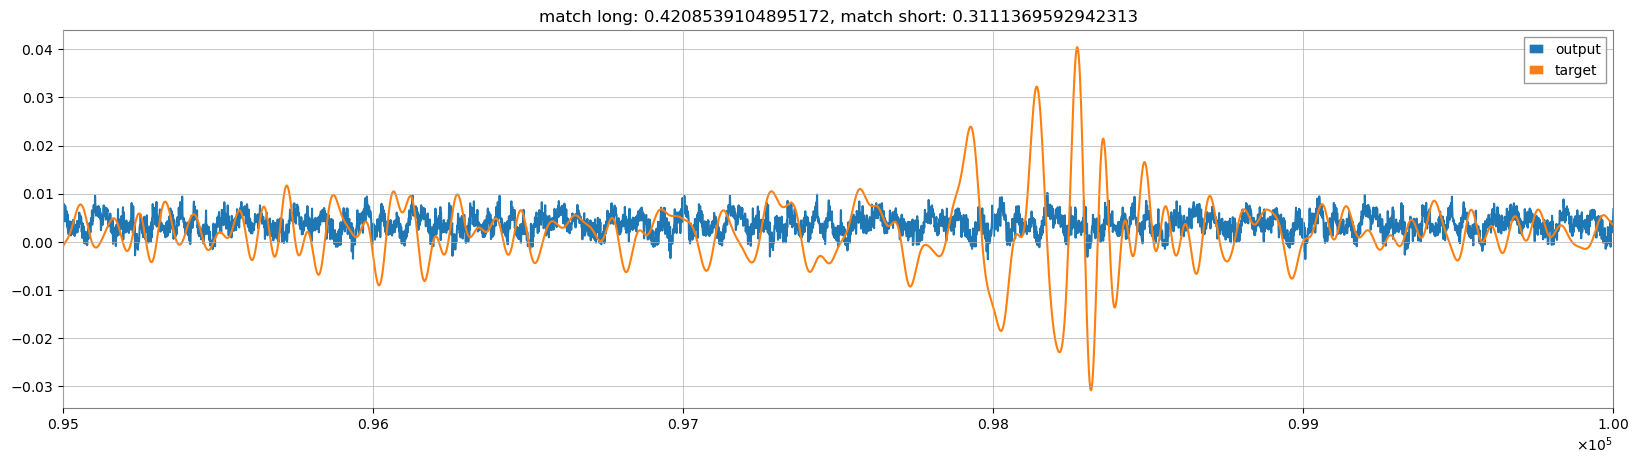

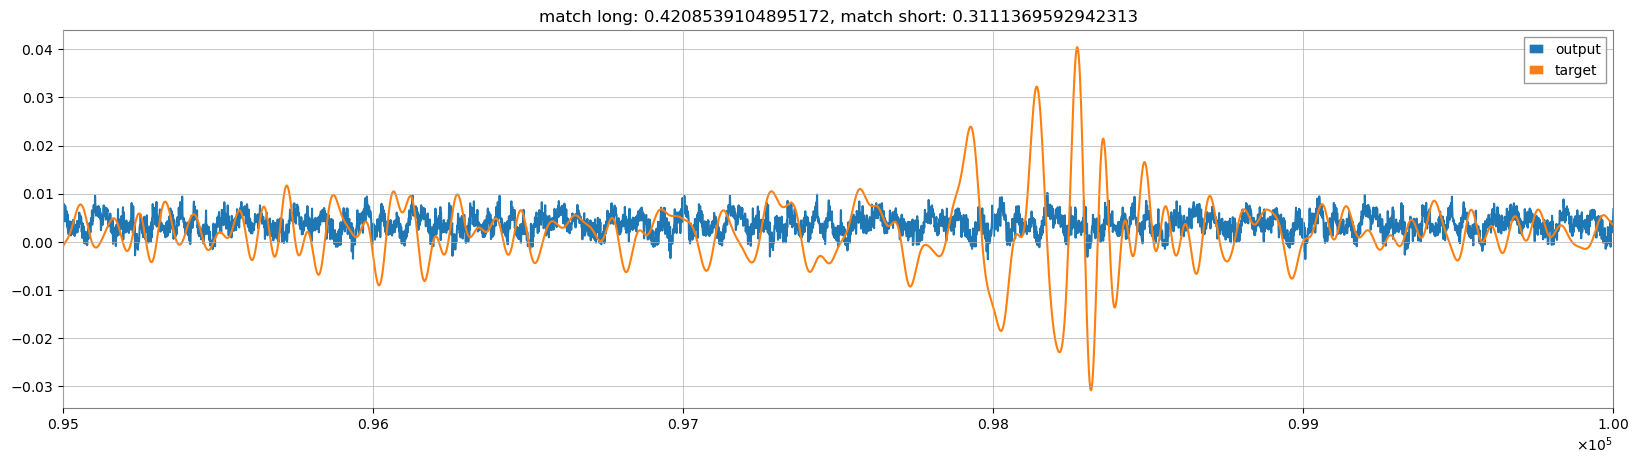

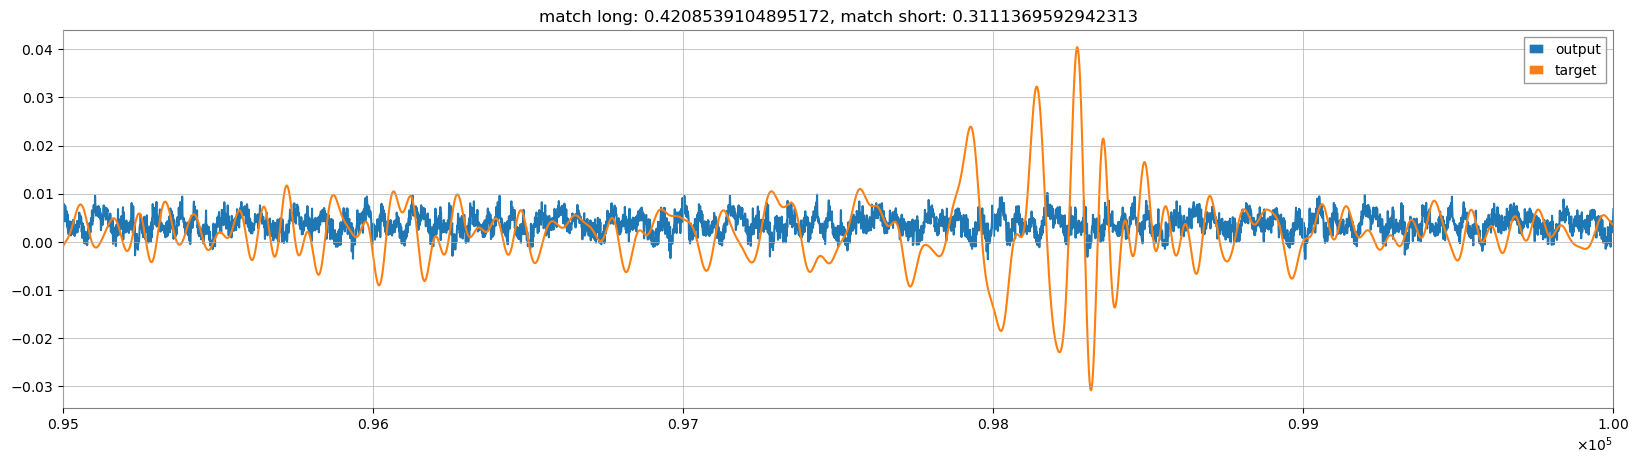

In [23]:
for i in range(denoised.shape[0]):
    long, short = metric(denoised[i],clean[i], mask[i])
    model_output = rebuild_forer(denoised[i])
    target_signal = rebuild_forer(clean[i])
    input = rebuild_forer(noisy[i])
    input_mask = rebuild_forer(mask[i])
    plt.figure(figsize=(20,5), dpi=100)
    # plt.plot(input, label='input')
    plt.plot(model_output, label='output')
    plt.plot(target_signal, label='target')
    # plt.plot(input_mask, label='mask')
    plt.title("match long: {}, match short: {}".format(long, short))
    print("match long: {}, match short: {}".format(long, short))
    plt.legend()
    # plt.figure(figsize=(20,5), dpi=100)
    # plt.plot(input, label='input')
    # plt.plot(target_signal, label='target')
    # plt.legend()
    plt.xlim(95000, 100000)
    # plt.xlim(25000, 30000)
    # plt.xlim(29900, 30000)
    # plt.xlim(97500, 98500)

In [4]:
dataset = DatasetTorchRealEvent()

Fetching real event data...


In [5]:
dataset.metric(denoised[0].reshape(1, 127, -1))

(0.4208539104895214, 0.28069363468373787)

In [37]:
dataset.metric(denoised[0].reshape(1, 127, -1))

(0.0056230709631048805, -0.01854820789982739)

In [ ]:
dataset.cut_from_long()

In [46]:
dataset.calc_matches( rebuild_forer(denoised[0].reshape(127, -1)),  dataset.cut_from_long(dataset.denoised_strain_valid) )

0.0056230709631048805

In [47]:
dataset.calc_matches( rebuild_forer(denoised[0].reshape(127, -1)),  rebuild_forer(clean[0]) )

0.4208539104895172

In [62]:
dataset.calc_matches( rebuild_forer(denoised[0].reshape(127, -1)),  rebuild_forer(dataset.target_signal[0]) )

0.4208539104895214

In [64]:
dataset.target_signal.shape

(1, 127, 2048)

(90000.0, 110000.0)

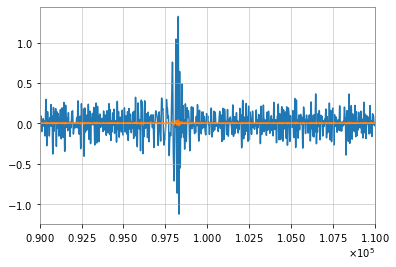

In [63]:
plt.plot(dataset.cut_from_long(dataset.denoised_strain_valid))
# plt.plot(rebuild_forer(clean[0]))
plt.plot(rebuild_forer(dataset.target_signal[0]))
plt.xlim(90000,110000)

In [27]:
dataset.calc_matches(dataset.rebuild_forer(data[0]), dataset.rebuild_forer(dataset[0][1]))

KeyError: 1

In [15]:
dataset.calc_matches(dataset.cut_for_target(dataset.rebuild_forer(data[0])), 
                     dataset.cut_for_target(dataset.rebuild_forer(dataset[0][1])))

KeyError: 1

KeyError: 1

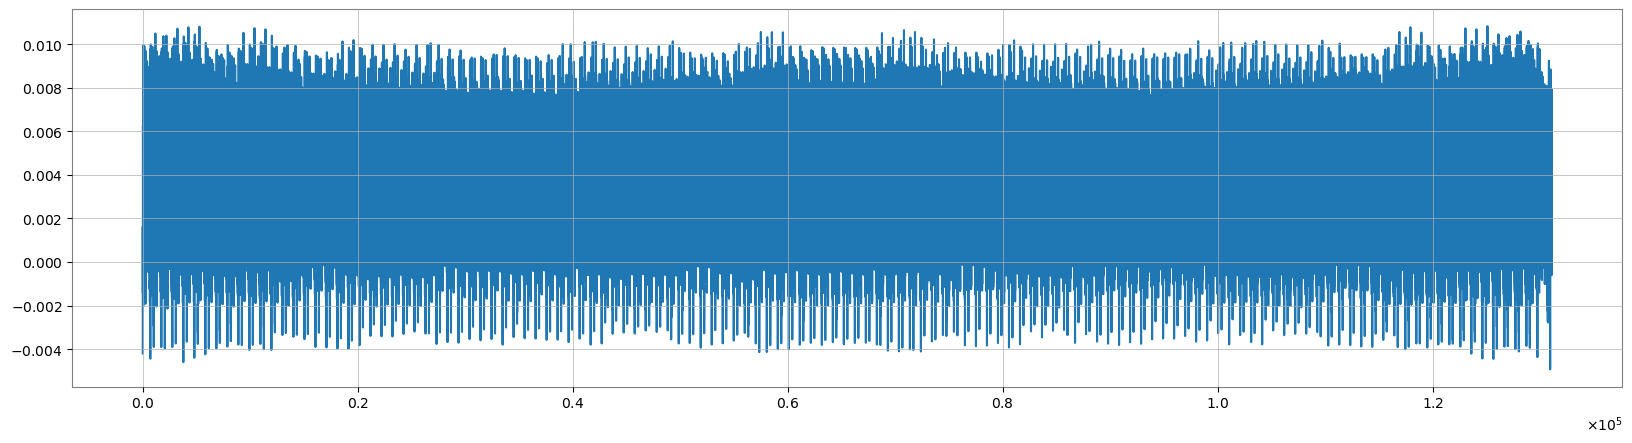

In [16]:
plt.figure(figsize=(20,5), dpi=100)
plt.plot(dataset.rebuild_forer(data[0]), label='output')
plt.plot(dataset.rebuild_forer(dataset[0][1]), label='target')
plt.legend()
plt.xlim(95000, 100000)
# plt.xlim(25000, 30000)
# plt.xlim(29900, 30000)
# plt.xlim(97500, 98500)

# Tmp

In [12]:
import torch
a = torch.ones([2, 4, 4], dtype=torch.float32)

In [13]:
b = torch.zeros([2, 1, 4, 4], dtype=torch.float32)

In [14]:
a*b

tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]])